In [1]:
using Distributions, TimeIt, ProgressMeter, PyPlot, JLD
include("zz_structures_DuLuSuSe.jl")
include("mbsampler.jl")

get_clustering (generic function with 1 method)

#### Load data:

In [2]:
d, Nobs = 2000, 3000
X = sprandn(d, Nobs, 5e-2)
X[1,:] = ones(Nobs)
nz = 50
ξ_true = spzeros(d)
ξ_true[1] = 3*rand()
nzind = sample(1:d, nz)
ξ_true[nzind[1:Int(nz/2)]] = rand(Uniform(7,10),Int(nz/2))
ξ_true[nzind[Int(nz/2)+1:end]] = -rand(Uniform(7,10),Int(nz/2));
y = [rand(Binomial(1, 1/(1+exp(-X[:,n]'ξ_true)))) for n in 1:Nobs];

#### Define prior:

In [3]:
σ02 = 1
prior = SS_prior(d, σ02);

#### Define model:

In [4]:
my_ll = ll_logistic_sp(X,y);
my_model = model(my_ll, prior);

#### Define minibatch sampler:

In [5]:
mb_size = 100
weights_het = spzeros(d, Nobs)
@showprogress for i in 1:d 
    nzind = X[i,:].nzind
    weights_het[i,nzind] = abs.(X[i,nzind])./sum(abs.(X[i,nzind]))
end

prob_het = 0.98
gs = Array{mbsampler}(d)
gs[1] = umbsampler(Nobs, mb_size)
@showprogress for i in 2:d 
    gs[i] = spwumbsampler(Nobs, mb_size, weights_het[i,:], prob_het)
end
gs_list = mbsampler_list(d,gs);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


#### Define output scheduler:

In [6]:
k = 100
A_xi = spzeros(k,d)
for i in 1:k 
    A_xi[i,i] = 1
end

In [25]:
# A_xi = ones(1,d)/d
A_hyp = ones(1,hyperparam_size(prior))/hyperparam_size(prior)
A_xi = eye(d)
# A_hyp = eye(hyperparam_size(prior))

opf = projopf(A_xi, A_hyp, 1000)
opt = maxa_opt(6*10^6, 2*10^6)
outp = outputscheduler(opf,opt)
bb = linear_bound(my_model.ll, my_model.pr, gs_list)
mstate = zz_state(d)
update_bound(bb, my_ll, prior, gs_list, mstate);

#### Define mbsampler + block Gibbs sampler list:

In [26]:
adapt_speed = "by_var"
L = 1
my_zz_sampler = zz_sampler(0, gs_list, bb, L, adapt_speed)
hyper_sampler = block_gibbs_sampler(5e3)
blocksampler = Array{msampler}(2)
blocksampler[1] = my_zz_sampler
blocksampler[2] = hyper_sampler;

#### Run sampler:

In [27]:
ZZ_block_sample(my_model, outp, blocksampler, mstate);

10% attempts in 10.62 mins 
20% attempts in 20.87 mins 
30% attempts in 31.12 mins 
Trimmed after 2000000 bouncing attempts 
40% attempts in 41.26 mins 
50% attempts in 50.68 mins 
60% attempts in 60.35 mins 
70% attempts in 69.79 mins 
80% attempts in 79.27 mins 
90% attempts in 88.92 mins 
100% attempts in 98.67 mins 


In [28]:
print(maximum(abs.(outp.opf.xi_mu - mstate.mu)), "\n")
print(maximum(abs.(outp.opf.xi_m2 - mstate.m2)))

2.865196186838471
37.27104826249396

* Number of bounces:

In [29]:
zz_bounces = sum(mstate.n_bounces)
hyp_bounces = outp.opf.tot_bounces-sum(mstate.n_bounces)
@printf("ZZ total bounces: %i, hyper bounces: %i", zz_bounces, hyp_bounces)

ZZ total bounces: 169828, hyper bounces: 112081

In [30]:
size(outp.opf.xi_skeleton,2)/outp.opt.max_attempts

0.027903166666666666

In [31]:
post_mean_gzz = outp.opf.xi_mu
# post_median_gzz = median(xi_samples,2);

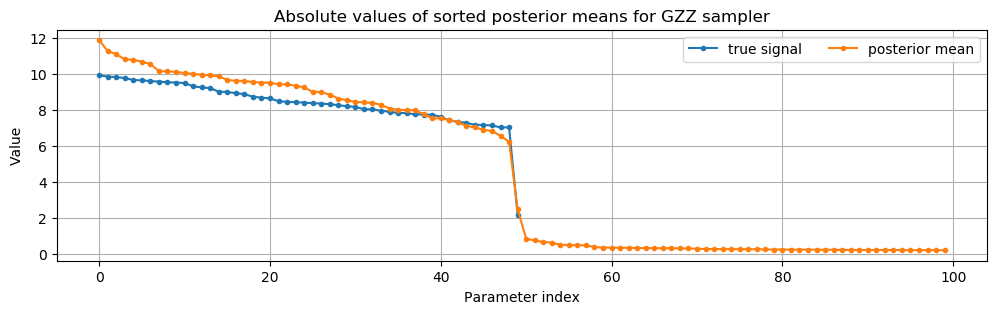

In [32]:
fig = figure(figsize=(12,3))
plot(sort(abs.(ξ_true.nzval), rev=true), "o-", markersize=3, label="true signal")
plot(sort(vec(abs.(post_mean_gzz)), rev=true)[1:100], "o-", markersize=3, label="posterior mean")
# plot(sort(vec(abs.(post_median_gzz)), rev=true)[1:50], "o-", markersize=3, label="posterior median")
grid(true)
title("Absolute values of sorted posterior means for GZZ sampler")
legend(ncol=3)
xlabel("Parameter index")
ylabel("Value")
savefig("plots/postmeansdcomplete2K.pdf", format="pdf", dpi=10000, bbox_inches="tight")

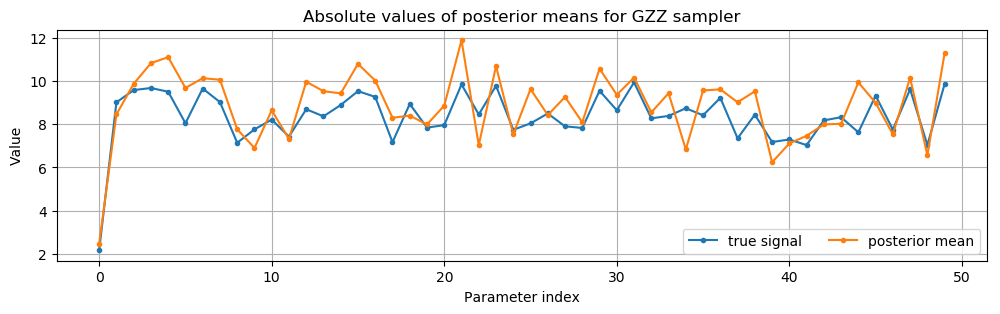

In [33]:
fig = figure(figsize=(12,3))
plot(abs.(ξ_true.nzval), "o-", markersize=3, label="true signal")
plot(vec(abs.(post_mean_gzz))[ξ_true.nzind], "o-", markersize=3, label="posterior mean")
grid(true)
title("Absolute values of posterior means for GZZ sampler")
legend(ncol=3)
xlabel("Parameter index")
ylabel("Value")
savefig("plots/postmeansd2K.pdf", format="pdf", dpi=10000, bbox_inches="tight")

### Effective sample size:

In [37]:
outp.opf.bt_skeleton[1,end]

15.003191227294888

In [74]:
h = 0.25
B = Int(round(outp.opf.bt_skeleton[1,end]/h))
ESS = compute_ESS(outp.opf, B)
print(mean(ESS))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


In [79]:
mean(ESS)

83.56430692035154

#### Confidence interval:

In [81]:
xi_sd = sqrt.(outp.opf.xi_m2 - outp.opf.xi_mu.^2)
ci = zeros(d,2)
ci[:,1] = outp.opf.xi_mu-3*xi_sd
ci[:,2] = outp.opf.xi_mu+3*xi_sd;

Progress:  94%|██████████████████████████████████████   |  ETA: 0:00:00

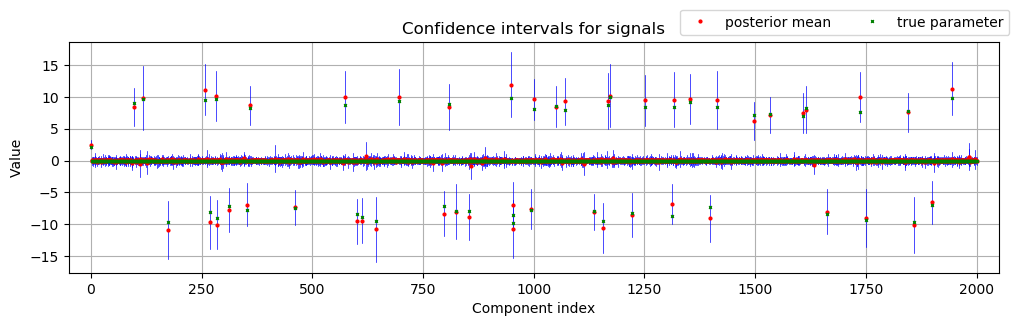

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


In [83]:
fig = figure(figsize=(12,3))
@showprogress for i in 1:d
    plot([i,i], ci[i,:], "b-", lw=0.5)
end
plot(1:d, outp.opf.xi_mu, "ro", markersize=2, label="posterior mean");
plot(1:d, ξ_true, "gx", markersize=2, label="true parameter")
grid(true)
xlim(-50,d+50)
xlabel("Component index")
ylabel("Value")
title("Confidence intervals for signals")
legend(ncol=2,bbox_to_anchor=(0.65, 1))
savefig("plots/CId2K.pdf", format="pdf", dpi=10000, bbox_inches="tight")

In [84]:
save("/home/postdoc/dsen/Desktop/GZZ_data/data/opf_d2K.jld", "opf", outp.opf)